In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import keras
from keras import layers
import librosa
import os

data_path = './dataset'

In [103]:
def extract_features(file_path, duration=30):
    try:
        y, sr = librosa.load(file_path, duration=duration)
        
        
        features = {}
        
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)

        # RMS Energy
        rms = librosa.feature.rms(y=y)[0]
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)

        # MFCCs (13 coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])

        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for i in range(12):
            features[f'chroma_{i+1}_mean'] = np.mean(chroma[i])
            features[f'chroma_{i+1}_std'] = np.std(chroma[i])

        # Tempo
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo

        # Spectral contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        for i in range(7):
            features[f'contrast_{i+1}_mean'] = np.mean(contrast[i])
            features[f'contrast_{i+1}_std'] = np.std(contrast[i])
        
        return features
        
    except Exception as e:
        print(e)
        return None

In [104]:

        
features_list = []
labels = []
file_count = 0

for genre in sorted(os.listdir(data_path)):
    genre_path = os.path.join(data_path, genre)
    if os.path.isdir(genre_path):
        files = [f for f in os.listdir(genre_path) if f.endswith(('.wav'))]
        for i, file in enumerate(files):
            file_path = os.path.join(genre_path, file)
            features = extract_features(file_path)
            if features:
                features_list.append(features)
                labels.append(genre)
                file_count += 1
            



print(f"Successfully processed {file_count} files")

df = pd.DataFrame(features_list)
df['genre'] = labels
        
       

/tmp/ipykernel_1587/3862687324.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=duration)
/home/junu/miniconda3/envs/prod/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



Successfully processed 999 files


In [105]:
df.to_csv('data.csv',index=False)

In [106]:
feature_columns = [col for col in df.columns if col != 'genre']

In [107]:
df.columns

Index(['spectral_centroid_mean', 'spectral_centroid_std',
       'spectral_rolloff_mean', 'spectral_rolloff_std',
       'spectral_bandwidth_mean', 'spectral_bandwidth_std', 'zcr_mean',
       'zcr_std', 'rms_mean', 'rms_std', 'mfcc_1_mean', 'mfcc_1_std',
       'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean',
       'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std',
       'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean',
       'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean',
       'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'mfcc_13_mean',
       'mfcc_13_std', 'chroma_1_mean', 'chroma_1_std', 'chroma_2_mean',
       'chroma_2_std', 'chroma_3_mean', 'chroma_3_std', 'chroma_4_mean',
       'chroma_4_std', 'chroma_5_mean', 'chroma_5_std', 'chroma_6_mean',
       'chroma_6_std', 'chroma_7_mean', 'chroma_7_std', 'chroma_8_mean',
       'chroma_8_std', 'chroma_9_mean', 'chroma_9_std', 'chroma_10_mean',
   

In [108]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

        
X = df[feature_columns].values
y = df['genre'].values

# Encode labels
y_encoded = label_encoder.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
        

In [109]:

num_classes = len(label_encoder.classes_)
print(num_classes)
dim = X_train.shape[1]
model = keras.Sequential([
        # Input layer 
        layers.Dense(1024, activation='sigmoid', input_shape=(dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),

        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
        
# Compile with Adam optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), # type: ignore
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model.summary()

10


/home/junu/miniconda3/envs/prod/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
his = model.fit(
            X_train_scaled, y_train,
            batch_size=128,
            epochs=50,
            validation_data=(X_test_scaled, y_test),
        
        )

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6961 - loss: 0.9293 - val_accuracy: 0.6750 - val_loss: 1.1417
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6399 - loss: 0.9752 - val_accuracy: 0.6850 - val_loss: 1.1114
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6767 - loss: 0.9486 - val_accuracy: 0.6850 - val_loss: 1.0833
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7282 - loss: 0.8432 - val_accuracy: 0.6850 - val_loss: 1.0584
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7358 - loss: 0.8367 - val_accuracy: 0.7000 - val_loss: 1.0343
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6819 - loss: 0.9160 - val_accuracy: 0.7000 - val_loss: 1.0076
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7066 - loss: 0.8784 - val_accuracy: 0.7000 - val_loss: 0.9822
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6985 - loss: 0.8393 - val_accuracy: 0.7150 - val_loss: 0.9633

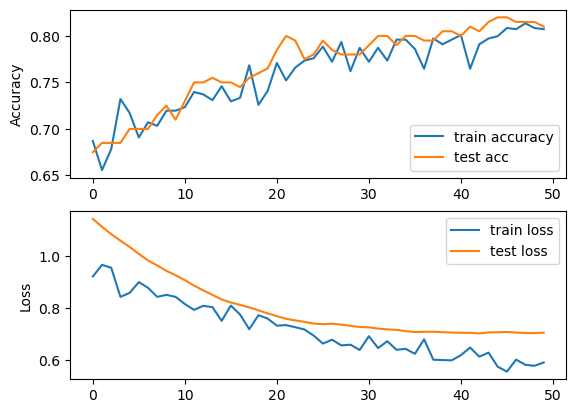

In [117]:
fig,axs = plt.subplots(2)

axs[0].plot(his.history['accuracy'],label='train accuracy')
axs[0].plot(his.history['val_accuracy'],label='test acc')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')



axs[1].plot(his.history['loss'],label='train loss')
axs[1].plot(his.history['val_loss'],label='test loss')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

plt.show()





7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


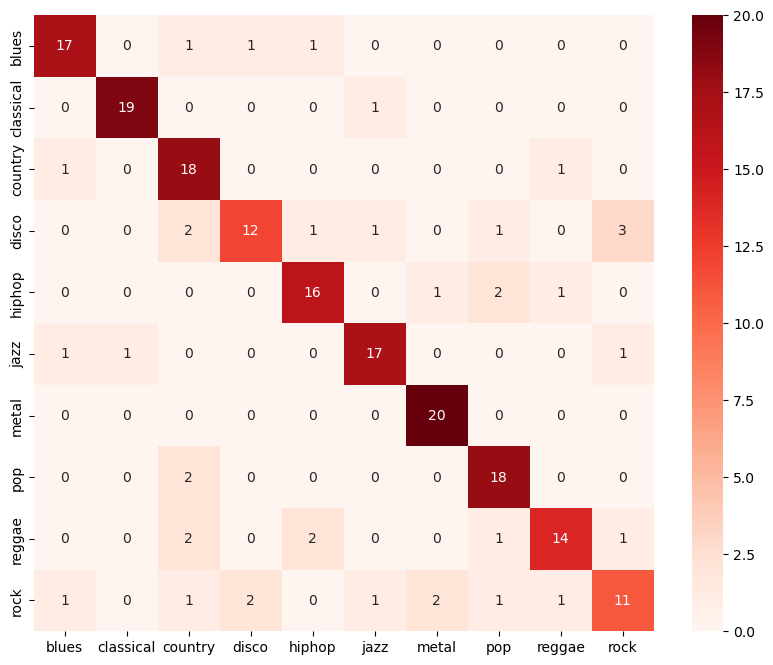

In [118]:

y_pred = model.predict(X_test_scaled).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=label_encoder.classes_, # type: ignore
            yticklabels=label_encoder.classes_) # type: ignore
plt.show()



In [119]:
test = 'test.wav'
    
features = extract_features(test)
feature_df = pd.DataFrame([features])
feature_scaled = scaler.transform(feature_df.values)

prediction = model.predict(feature_scaled)
predicted_class = np.argmax(prediction)
confidence = np.max(prediction)
genre = label_encoder.inverse_transform([predicted_class])[0]

print(genre, confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
country 0.82607466
